# ModularSimulator Kalman filter with semi-empirical rudder and propeller

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes, ExtendedKalmanModular
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
#from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.nonlinear_vmm_equations import X_eom, Y_eom, N_eom, fx_eq, fy_eq, mz_eq
from vessel_manoeuvring_models.extended_kalman_filter import extended_kalman_filter
import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[07/06/23 15:36:47] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=703092;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=236398;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/06/23 15:36:53] INFO     Kedro project phd                                                      ]8;id=799306;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=852168;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=398121;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=210062;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=331073;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=350077;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 get_ipython().run_line_magic('reload_kedro', '')                                            │
│    2 ship='wPCC'                                                                                 │
│ ❱  3 time_series = catalog.load(f"{ship}.tests")                                                 │
│    4 time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")             │
│    5 ship_data = catalog.load(f"{ship}.ship_data")                                               │
│    6 exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")                      │
│                                                                                                  │
│ /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py:341 in load   │
│                                                                                                  │
│   338 │   │   │   >>> df = io.load("cars")                                                       │
│   339 │   │   """                                                                                │
│   340 │   │   load_version = Version(version, None) if version else None                         │
│ ❱ 341 │   │   dataset = self._get_dataset(name, version=load_version)                            │
│   342 │   │                                                                                      │
│   343 │   │   self._logger.info(                                                                 │
│   344 │   │   │   "Loading data from '%s' (%s)...", name, type(dataset).__name__                 │
│                                                                                                  │
│ /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py:300 in        │
│ _get_dataset                                                                                     │
│                                                                                                  │
│   297 │   │   │   │   │   suggestions = ", ".join(matches)                                       │
│   298 │   │   │   │   │   error_msg += f" - did you mean one of these instead: {suggestions}"    │
│   299 │   │   │                                                                                  │
│ ❱ 300 │   │   │   raise DataSetNotFoundError(error_msg)                                          │
│   301 │   │                                                                                      │
│   302 │   │   data_set = self._data_sets[data_set_name]                                          │
│   303 │   │   if version and isinstance(data_set, AbstractVersionedDataSet):                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
DataSetNotFoundError: DataSet 'wPCC.tests' not found in the catalog - did you mean one of these instead: 
wPCC.units, wPCC.models, 7m.tests

In [4]:
model = model_loader["VCT_MDL_resistance"]()
for name,subsystem in model.subsystems.items():
    subsystem.create_partial_derivatives()

In [5]:
name

'rudders'

In [6]:
hull = model.subsystems['hull']
hull.partial_derivatives

{'ddx_0X_H': 0,
 'ddy_0X_H': 0,
 'ddpsiX_H': 0,
 'dduX_H': -L**2*rho*u*(X0*(u**2 + v**2)**(3/2) + Xu*u*(u**2 + v**2) + sqrt(u**2 + v**2)*(L**2*Xrr*r**2 + L*Xvr*r*v + Xvv*v**2))/(2*(u**2 + v**2)**(3/2)) + L**2*rho*(3*X0*u*sqrt(u**2 + v**2) + 2*Xu*u**2 + Xu*(u**2 + v**2) + u*(L**2*Xrr*r**2 + L*Xvr*r*v + Xvv*v**2)/sqrt(u**2 + v**2))/(2*sqrt(u**2 + v**2)),
 'ddvX_H': -L**2*rho*v*(X0*(u**2 + v**2)**(3/2) + Xu*u*(u**2 + v**2) + sqrt(u**2 + v**2)*(L**2*Xrr*r**2 + L*Xvr*r*v + Xvv*v**2))/(2*(u**2 + v**2)**(3/2)) + L**2*rho*(3*X0*v*sqrt(u**2 + v**2) + 2*Xu*u*v + v*(L**2*Xrr*r**2 + L*Xvr*r*v + Xvv*v**2)/sqrt(u**2 + v**2) + sqrt(u**2 + v**2)*(L*Xvr*r + 2*Xvv*v))/(2*sqrt(u**2 + v**2)),
 'ddrX_H': L**2*rho*(2*L**2*Xrr*r + L*Xvr*v)/2,
 'ddx_0Y_H': 0,
 'ddy_0Y_H': 0,
 'ddpsiY_H': 0,
 'dduY_H': L**2*Yv*rho*u*v/sqrt(u**2 + v**2) - L**2*rho*u*v*(L**2*Yvrr*r**2 + Yv*(u**2 + v**2) + Yvvv*v**2)/(2*(u**2 + v**2)**(3/2)),
 'ddvY_H': -L**2*rho*v**2*(L**2*Yvrr*r**2 + Yv*(u**2 + v**2) + Yvvv*v**2)/(2*(u**2 + v**

In [7]:
model.subsystems

{'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7f806f692080>,
 'propellers': <vessel_manoeuvring_models.models.subsystem.EquationSubSystem at 0x7f806f67e9e0>,
 'rudders': <vessel_manoeuvring_models.models.semiempirical_rudder.SemiempiricalRudderSystem at 0x7f806f67dcf0>}

In [8]:
model.create_predictor_and_jacobian()

<function _lambdifygenerated(I_z, L, Nrdot, Nvdot, Xudot, Yrdot, Yvdot, ddrN_H, ddrN_R, ddrX_H, ddrX_P, ddrX_R, ddrY_H, ddrY_R, dduN_H, dduN_R, dduX_H, dduX_P, dduX_R, dduY_H, dduY_R, ddvN_H, ddvN_R, ddvX_H, ddvX_P, ddvX_R, ddvY_H, ddvY_R, h, m, psi, r, rho, u, v, x_G)>

In [9]:
rudders = model.subsystems['rudders']

In [10]:
ek = ExtendedKalmanModular(model=model)

In [11]:
Cd = np.array(
        [
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
        ]
    )

E = np.array(
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ],
)

In [12]:
raw_data = time_series['22773']()
data = load(raw_data)
data = add_thrust(data, thrust_channels=['Prop/PS/Thrust','Prop/SB/Thrust'])
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
#data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)

data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
g_=9.81
data['g'] = g_

In [27]:
#ek_covariance_input = yaml.safe_load("""
#process_variance:
#  u : 0.003
#  v : 0.003
#  r : 0.019  # [deg]
#measurement_error_max:
#  positions: 0.05
#  psi: 0.5  # [deg]
#"""
#)

ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.3
  v : 0.3
  r : 5  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)  
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes = {key:np.array(value) for key,value in covariance_matrixes.items()}

In [28]:
x0 = initial_state(data=data)

In [36]:
x0

{'x0': 0.013495544229640898,
 'y0': -3.336569832830159e-05,
 'psi': 8.726646259926696e-05,
 'u': 0.7538132690124566,
 'v': -0.0005360280056312573,
 'r': 0.0017483013643210619}

In [29]:
x0_ = pd.Series(x0)[["x0", "y0", "psi", "u", "v", "r"]].values

In [30]:
time_steps = ek.filter(
        data=data,
        **covariance_matrixes, 
        E=E,
        Cd=Cd,
        input_columns=['delta','rev'],
        x0_=x0_,
    )

In [31]:
ek.smoother(time_steps);

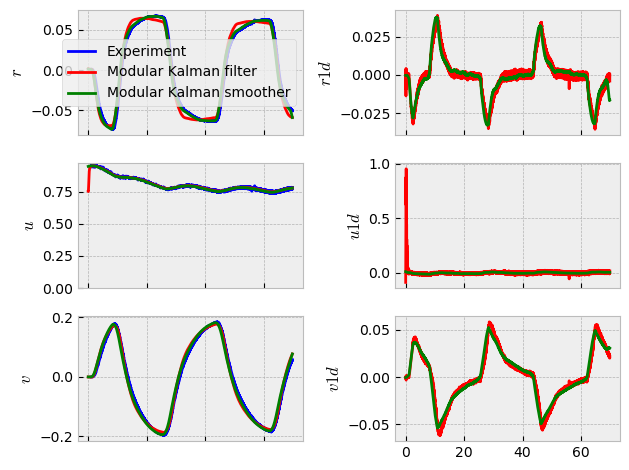

In [35]:
dataframes = {
    'Experiment':data.rolling(window=100).mean().drop(columns=['u1d','v1d','r1d']),
    'Modular Kalman filter':ek.df_kalman,
    'Modular Kalman smoother':ek.df_smooth,
}
plot(dataframes, keys=['u','v','r','u1d','v1d','r1d']);
